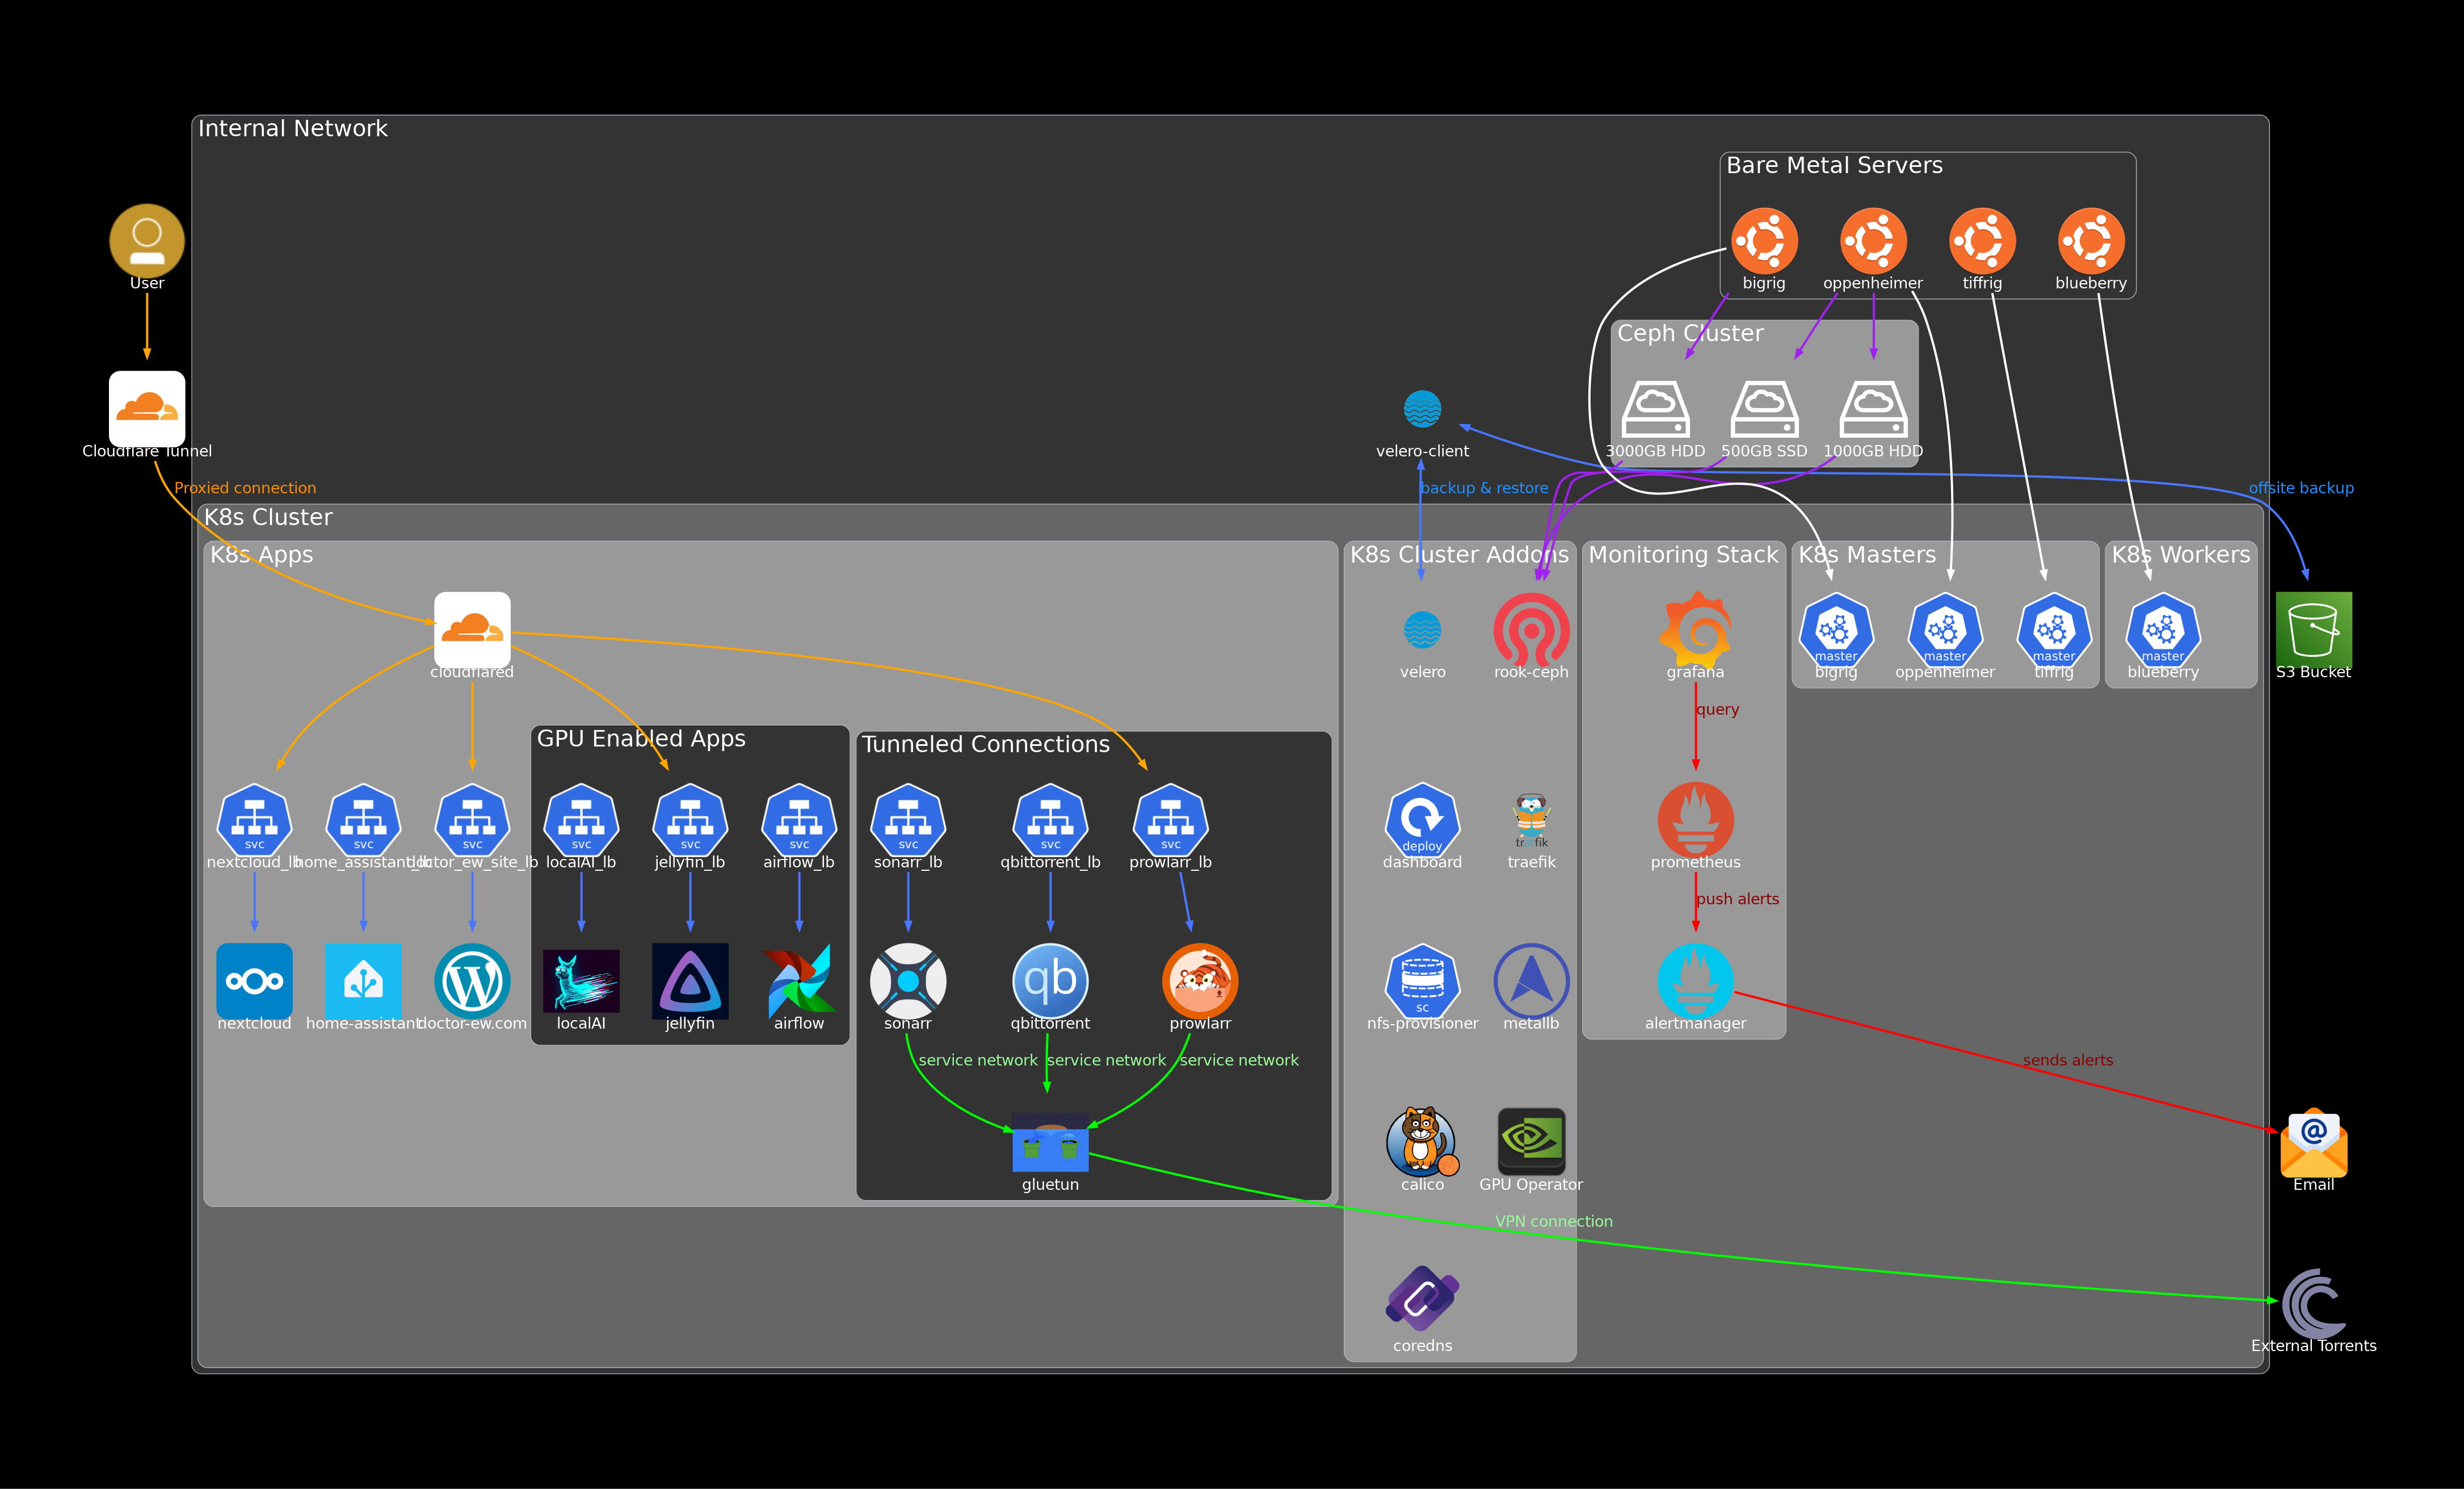

In [9]:
from diagrams                   import Diagram, Cluster, Edge
from diagrams.custom            import Custom
from diagrams.generic.os        import Ubuntu
from diagrams.k8s.compute       import Deployment
from diagrams.k8s.controlplane  import API
from diagrams.k8s.infra         import Master, Node
from diagrams.k8s.network       import Ingress
from diagrams.k8s.storage       import StorageClass
from diagrams.k8s.network       import Service
from diagrams.oci.storage       import StorageGatewayWhite
from diagrams.ibm.user          import User
from diagrams.onprem.container  import Docker

# Helper functions
def orient_vertical(node_list, edge_attr, columns):
    # connect k8s cluster addons one to the next to force vertical orientation
    column_height = len(node_list) // columns
    column_count = 0
    for i in range(len(node_list) - 1):
        if i == 0:
            node_list[i] >> Edge(**edge_attr) >> node_list[i + 1]
            continue
        if i % column_height == 0:
            column_count += 1
            if column_count < columns:
                pass
            else:
                node_list[i] >> Edge(**edge_attr) >> node_list[i + 1]
        else:
            try:
                node_list[i] >> Edge(**edge_attr) >> node_list[i + 1]
            except IndexError:
                pass

# Attributes
## node
base_node_attr      = { "fontcolor": "white", "fontsize": "20", "margin": "0.11,0.1" }
k8s_node_node_attr  = base_node_attr | { "group": "k8s_nodes" }
baremetal_node_attr = base_node_attr | { "group": "baremetal_nodes" }
k8s_app_node_attr   = base_node_attr | { "group": "k8s_apps" }
k8s_app_lb_attr     = base_node_attr | { "group": "k8s_apps_lb" }
docker_node_attr    = base_node_attr | { "group": "docker_nodes" }
k8s_addon_node_attr = base_node_attr | { "group": "k8s_addons" }
ceph_node_attr      = base_node_attr | { "group": "ceph_nodes" }

## edge
base_edge_attr   = { "color": "white", "penwidth": "3", "overlap": "true" }
blue_edge_attr   = base_edge_attr | { "color": "royalblue1", "fontcolor": "dodgerblue", "fontsize": "20" }
orange_edge_attr = base_edge_attr | { "color": "orange", "fontcolor": "darkorange", "fontsize": "20" }
white_edge_attr  = base_edge_attr | { "color": "white" }
lblue_edge_attr  = base_edge_attr | { "color": "dodgerblue" }
green_edge_attr  = base_edge_attr | { "color": "green", "fontcolor": "palegreen", "fontsize": "20" }
red_edge_attr    = base_edge_attr | { "color": "red", "fontcolor": "darkred", "fontsize": "20" }
dgreen_edge_attr = base_edge_attr | { "color": "darkgreen" }
gray_edge_attr   = base_edge_attr | { "color": "gray" }
purple_edge_attr = base_edge_attr | { "color": "purple" }
invis_edge_attr  = base_edge_attr | { "style": "invis" }

## cluster
base_cluster_attr  = { "fontcolor": "white", "fontsize": "30", "bgcolor": "gray20" }
internal_attr      = base_cluster_attr | { "bgcolor": "gray20" }
cluster1_attr      = base_cluster_attr | { "bgcolor": "gray40" }
baremetal_attr     = base_cluster_attr | { "bgcolor": "gray20" }
cluster2_attr      = base_cluster_attr | { "bgcolor": "gray60" }
invis_cluster_attr = { "bgcolor": "none", "style": "invis" }

diagram_attr      = { "fontcolor": "white", "fontsize": "72", "bgcolor": "black", "layout": "dot", "overlap": "false", "splines": "true", "concentrate": "false", "mclimit": "1.0" }

# Clusters and Nodes
with Diagram("", graph_attr=diagram_attr, show=False, direction="TB") as diagram:
    user               = User("User", **base_node_attr)
    email              = Custom("Email", "./custom_icons/email.png", **base_node_attr)
    cloudflare_tunnel  = Custom("Cloudflare Tunnel", "./custom_icons/cloudflare.png", **base_node_attr)
    external_resources = Custom("External Torrents", "./custom_icons/torrent.png", **base_node_attr)
    s3_bucket          = Custom("S3 Bucket", "./custom_icons/aws-s3.png", **base_node_attr)

    with Cluster("Internal Network", graph_attr=internal_attr):
        velero_client = Custom("velero-client", "./custom_icons/velero.png", **k8s_app_node_attr)

        with Cluster("Ceph Cluster", graph_attr=cluster2_attr):
            irma = StorageGatewayWhite("3000GB HDD", **ceph_node_attr)
            silverstick = StorageGatewayWhite("500GB SSD", **ceph_node_attr)
            blackbox = StorageGatewayWhite("1000GB HDD", **ceph_node_attr)

            ceph_osds = [irma, silverstick, blackbox]

        with Cluster("Bare Metal Servers", graph_attr=baremetal_attr):
            bigrig      = Ubuntu("bigrig", **baremetal_node_attr)
            oppenheimer = Ubuntu("oppenheimer", **baremetal_node_attr)
            tiffrig     = Ubuntu("tiffrig", **baremetal_node_attr)
            blueberry   = Ubuntu("blueberry", **baremetal_node_attr)

            baremetal_servers = [oppenheimer, bigrig, tiffrig, blueberry]
        
        with Cluster("K8s Cluster", graph_attr=cluster1_attr):
            # k8s_controlplane = API("Control Plane", **k8s_node_node_attr)

            with Cluster("K8s Masters", graph_attr=cluster2_attr):
                k8s_oppenheimer = Master("oppenheimer", **k8s_node_node_attr)
                k8s_bigrig      = Master("bigrig", **k8s_node_node_attr)
                k8s_tiffrig      = Master("tiffrig",**k8s_node_node_attr)

                k8s_masters = [k8s_oppenheimer, k8s_bigrig, k8s_tiffrig]

            with Cluster("K8s Workers", graph_attr=cluster2_attr):
                k8s_blueberry   = Master("blueberry", **k8s_node_node_attr)

                k8s_workers = [k8s_blueberry]
                
            with Cluster("K8s Apps", graph_attr=cluster2_attr):
                cloudflared = Custom("cloudflared", "./custom_icons/cloudflare.png", **k8s_app_node_attr)

                with Cluster("", graph_attr=invis_cluster_attr):
                    nextcloud    = Custom("nextcloud", "./custom_icons/nextcloud.png", **k8s_app_node_attr)
                    nextcloud_lb = Custom("nextcloud_lb", "./custom_icons/loadbalancer.png", **k8s_app_lb_attr)
                with Cluster("", graph_attr=invis_cluster_attr):
                    home_assistant    = Custom("home-assistant", "./custom_icons/homeassistant.png", **k8s_app_node_attr)
                    home_assistant_lb = Custom("home_assistant_lb", "./custom_icons/loadbalancer.png", **k8s_app_lb_attr)
                with Cluster("", graph_attr=invis_cluster_attr):
                    doctor_ew_site    = Custom("doctor-ew.com", "./custom_icons/wordpress.png", **k8s_app_node_attr)
                    doctor_ew_site_lb = Custom("doctor_ew_site_lb", "./custom_icons/loadbalancer.png", **k8s_app_lb_attr)

                with Cluster("GPU Enabled Apps", graph_attr=internal_attr):
                    with Cluster("", graph_attr=invis_cluster_attr):
                        airflow     = Custom("airflow", "./custom_icons/airflow.png", **k8s_app_node_attr)
                        airflow_lb  = Custom("airflow_lb", "./custom_icons/loadbalancer.png", **k8s_app_lb_attr)
                    with Cluster("", graph_attr=invis_cluster_attr):
                        jellyfin    = Custom("jellyfin", "./custom_icons/jellyfin.png", **k8s_app_node_attr)
                        jellyfin_lb = Custom("jellyfin_lb", "./custom_icons/loadbalancer.png", **k8s_app_lb_attr)
                    with Cluster("", graph_attr=invis_cluster_attr):
                        localAI    = Custom("localAI", "./custom_icons/localai.jpeg", **k8s_app_node_attr)
                        localAI_lb = Custom("localAI_lb", "./custom_icons/loadbalancer.png", **k8s_app_lb_attr)

                with Cluster("Tunneled Connections", graph_attr=internal_attr):
                    gluetun     = Custom("gluetun", "./custom_icons/gluetun.png", **docker_node_attr)
                    qbittorrent = Custom("qbittorrent", "./custom_icons/qbittorrent.png", **docker_node_attr)
                    prowlarr    = Custom("prowlarr", "./custom_icons/prowlarr.png", **k8s_app_node_attr)
                    sonarr      = Custom("sonarr", "./custom_icons/sonarr.png", **k8s_app_node_attr)

                    tunneled_connections = [gluetun, qbittorrent, prowlarr, sonarr]

                    prowlarr_lb       = Custom("prowlarr_lb", "./custom_icons/loadbalancer.png", **k8s_app_lb_attr)
                    qbittorrent_lb    = Custom("qbittorrent_lb", "./custom_icons/loadbalancer.png", **k8s_app_lb_attr)
                    sonarr_lb         = Custom("sonarr_lb", "./custom_icons/loadbalancer.png", **k8s_app_lb_attr)

            with Cluster("Monitoring Stack", graph_attr=cluster2_attr):
                prometheus   = Custom("prometheus", "./custom_icons/prometheus.png", **k8s_addon_node_attr | {"fillcolor": "white"})
                grafana      = Custom("grafana", "./custom_icons/grafana.png", **k8s_addon_node_attr)
                alertmanager = Custom("alertmanager", "./custom_icons/alertmanager.png", **k8s_addon_node_attr)

                monitoring_stack = [ prometheus, grafana, alertmanager ]

            with Cluster("K8s Cluster Addons", graph_attr=cluster2_attr):
                dashboard       = Deployment("dashboard", **k8s_addon_node_attr)
                nfs_provisioner = StorageClass("nfs-provisioner", **k8s_addon_node_attr)
                calico          = Custom("calico", "./custom_icons/calico.png", **k8s_addon_node_attr)
                coredns         = Custom("coredns", "./custom_icons/coredns.png", **k8s_addon_node_attr)
                rook_ceph       = Custom("rook-ceph", "./custom_icons/ceph.png", **k8s_addon_node_attr)
                traefik         = Custom("traefik", "./custom_icons/traefik.png", **k8s_addon_node_attr)
                metallb         = Custom("metallb", "./custom_icons/metallb.png", **k8s_addon_node_attr)
                gpu_operator    = Custom("GPU Operator", "./custom_icons/nvidia.png", **k8s_app_node_attr)
                velero          = Custom("velero", "./custom_icons/velero.png", **k8s_app_node_attr)

                k8s_cluster_addons = [velero, dashboard, nfs_provisioner, calico, coredns, rook_ceph, traefik, metallb, gpu_operator]
    
# Edge Connections
## baremetal nodes to k8s nodes
oppenheimer >> Edge(**white_edge_attr) >> k8s_oppenheimer
bigrig      >> Edge(**white_edge_attr) >> k8s_bigrig
tiffrig     >> Edge(**white_edge_attr) >> k8s_tiffrig
blueberry   >> Edge(**white_edge_attr) >> k8s_blueberry

## k8s loadbalancers
jellyfin_lb       >> Edge(**blue_edge_attr) >> jellyfin
nextcloud_lb      >> Edge(**blue_edge_attr) >> nextcloud
prowlarr_lb       >> Edge(**blue_edge_attr) >> prowlarr
home_assistant_lb >> Edge(**blue_edge_attr) >> home_assistant
qbittorrent_lb    >> Edge(**blue_edge_attr) >> qbittorrent
doctor_ew_site_lb >> Edge(**blue_edge_attr) >> doctor_ew_site
airflow_lb        >> Edge(**blue_edge_attr) >> airflow
localAI_lb        >> Edge(**blue_edge_attr) >> localAI
sonarr_lb         >> Edge(**blue_edge_attr) >> sonarr

# metallb >> Edge(**white_edge_attr | { "fontcolor": "white", "fontsize": "20" }) >> k8s_loadbalancers

## Force vertical orientation
orient_vertical(k8s_cluster_addons, invis_edge_attr, 2)

## tunneled connections
qbittorrent >> Edge(**green_edge_attr, label="service network") >> gluetun
prowlarr    >> Edge(**green_edge_attr, label="service network") >> gluetun
sonarr      >> Edge(**green_edge_attr, label="service network") >> gluetun
gluetun     >> Edge(**green_edge_attr, label="VPN connection") >> external_resources

## k8s monitoring
# prometheus   << Edge(**red_edge_attr, label="scrape stats") >> k8s_loadbalancers
prometheus   >> Edge(**red_edge_attr, label="push alerts") >> alertmanager
alertmanager >> Edge(**red_edge_attr, label="sends alerts") >> email
grafana      >> Edge(**red_edge_attr, label="query") >> prometheus

## end user interactions
user              >> Edge(**orange_edge_attr) >> cloudflare_tunnel
cloudflare_tunnel >> Edge(**orange_edge_attr, label="Proxied connection") >> cloudflared
cloudflared       >> Edge(**orange_edge_attr) >> nextcloud_lb
cloudflared       >> Edge(**orange_edge_attr) >> jellyfin_lb
cloudflared       >> Edge(**orange_edge_attr) >> doctor_ew_site_lb
cloudflared       >> Edge(**orange_edge_attr) >> prowlarr_lb

## Ceph Cluster
bigrig      >> Edge(**purple_edge_attr) >> irma
oppenheimer >> Edge(**purple_edge_attr) >> silverstick
oppenheimer >> Edge(**purple_edge_attr) >> blackbox

ceph_osds >> Edge(**purple_edge_attr) >> rook_ceph

## Backup
velero_client << Edge(**blue_edge_attr, label="backup & restore") >> velero
velero_client << Edge(**blue_edge_attr | { "fontcolor": "dodgerblue", "fontsize": "20" }, label="offsite backup") >> s3_bucket

diagram